# 2_Prototype_model

In this notebook, we will use BigQuery and Pandas to create a small subsample dataset and then use this subdataset to develope a DNN model locally with Keras.

## Import necessary libraries & Set up environment variables 

In [1]:
import os
from google.cloud import bigquery
import pandas as pd
import numpy as np
import datetime
import shutil
import tensorflow as tf
print(tf.__version__)

2.3.4


In [2]:
# for good-looking plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
sns.set_context('talk')
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
params = {'legend.fontsize': 12,
          'figure.figsize': (10, 5),
          'axes.labelsize': 12,
          'axes.titlesize':14,
          'xtick.labelsize':12,
          'ytick.labelsize':12}
plt.rcParams.update(params)

In [3]:
PROJECT = "predict-babyweight-10142021"
BUCKET = PROJECT
REGION = "us-central1"

os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET 
os.environ["REGION"] = REGION

In [4]:
%%bash
if ! gsutil ls|grep -q gs://${BUCKET}/; then
    gsutil mb -l ${REGION} gs://${BUCKET}
fi

## Create a small representative datasets by sampling using BigQuery

In [5]:
bq = bigquery.Client()

We're going to make a series of queries to check if our bucketing values result in the correct sizes of each of our dataset splits and then adjust accordingly. Therefore, to make the code more compact and reusable, let's define two handy functions:

In [6]:
def display_dataframe_head_from_query(query, count=10):
    """Displays count rows from dataframe head from query.
    """
    query_final=query + f" LIMIT {count}"
    df = bq.query(query_final).to_dataframe()
    
    return df.head(count)

In [7]:
def count_rows_from_query(query):
    """Displays count rows from dataframe head from query.
    """
    new_query = f"SELECT COUNT(*) FROM ({query})"
    df = bq.query(new_query).to_dataframe()
    num_rows_all = df['f0_'][0]
    print('*** Number of all records found:',num_rows_all)
    return

In [8]:
# Get label, features, and columns used to hash and split into buckets
query_2003 = """
SELECT
    weight_pounds,
    is_male,
    mother_age,
    plurality,
    gestation_weeks,
    IFNULL(CAST(cigarette_use AS STRING), "Unknown") AS cigarette_use,
    IFNULL(CAST(alcohol_use AS STRING), "Unknown") AS alcohol_use,
    year,
    month,
    COALESCE(wday, day, 0) AS date,
    IFNULL(state, "Unknown") AS state,
    IFNULL(mother_birth_state, "Unknown") AS mother_birth_state
FROM
    publicdata.samples.natality
WHERE
    year > 2002
    AND weight_pounds > 0
    AND mother_age > 0
    AND plurality > 0
    AND gestation_weeks > 0
"""
count_rows_from_query(query_2003)
display_dataframe_head_from_query(query_2003)

*** Number of all records found: 25037335


,weight_pounds,is_male,mother_age,plurality,gestation_weeks,cigarette_use,alcohol_use,year,month,date,state,mother_birth_state
0,6.686620,False,19,1,38,false,false,2003,3,2,AK,PR
1,6.375769,False,22,1,37,false,false,2003,6,3,AL,AL
2,8.249698,False,22,1,39,Unknown,Unknown,2003,3,7,CA,MX
3,5.436599,False,26,1,38,false,false,2003,12,2,AL,AL
4,8.375361,True,32,1,39,Unknown,Unknown,2003,9,3,CA,MX
5,7.125340,False,30,1,40,false,false,2003,1,6,AZ,AZ
6,1.840860,True,31,2,24,Unknown,Unknown,2003,5,7,CA,CA
7,7.627994,False,21,1,39,Unknown,Unknown,2003,1,7,CA,CA
8,2.687435,True,18,1,32,false,false,2003,3,7,AL,AL
9,8.000575,True,35,1,38,false,false,2003,12,6,AZ,YY


Next query will combine our hash columns and will leave us just with our label, features, and our hash values.

In [9]:
query_with_hash_vals=f"""
SELECT
    weight_pounds,
    is_male,
    mother_age,
    plurality,
    gestation_weeks,
    cigarette_use,
    alcohol_use,
    ABS(FARM_FINGERPRINT(
        CONCAT(
            CAST(year AS STRING),
            CAST(month AS STRING),
            CAST(date AS STRING),
            CAST(state AS STRING),
            CAST(mother_birth_state AS STRING)
        )
    )) AS hash_values
FROM
    ({query_2003})
"""
count_rows_from_query(query_with_hash_vals)
display_dataframe_head_from_query(query_with_hash_vals)

*** Number of all records found: 25037335


,weight_pounds,is_male,mother_age,plurality,gestation_weeks,cigarette_use,alcohol_use,hash_values
0,6.686620,False,19,1,38,false,false,974019879576970363
1,6.375769,False,22,1,37,false,false,4705104071905317631
2,8.249698,False,22,1,39,Unknown,Unknown,5288487779815714994
3,5.436599,False,26,1,38,false,false,7153589864032164488
4,8.375361,True,32,1,39,Unknown,Unknown,631296104170775089
5,7.125340,False,30,1,40,false,false,3413677974385376413
6,1.840860,True,31,2,24,Unknown,Unknown,482746296875782448
7,7.627994,False,21,1,39,Unknown,Unknown,3278838361491679962
8,2.687435,True,18,1,32,false,false,637712993747683735
9,8.000575,True,35,1,38,false,false,4902913671939109754


The next query is going to find the counts of each of the unique `hash_values`. This will be our first step at making actual hash buckets for our split via the `GROUP BY`.

In [10]:
# count number of records in each unique hash
query_unique_hash_vals = f"""
SELECT
    hash_values,
    COUNT(*) AS num_records
FROM
    ({query_with_hash_vals})
GROUP BY
    hash_values
"""

count_rows_from_query(query_unique_hash_vals)
display_dataframe_head_from_query(query_unique_hash_vals)

*** Number of all records found: 329809


,hash_values,num_records
0,1115623580968852252,3330
1,5186567457509693578,770
2,228777710046848525,435
3,6317365661972856318,15
4,5198518853237582211,225
5,7304790014736362876,304
6,2440016239182192746,159
7,8828228969818137965,1329
8,71835286728888592,3
9,4064623686216945563,1893


The query below performs a second layer of bucketing where now for each of these bucket indices we count the number of records.

In [11]:
# count number of records in 100 hash-buckets (100 indices)
query_hash_bucket_index = f"""
SELECT
    MOD(hash_values, 100) AS bucket_index,
    SUM(num_records) AS num_records,
    SUM(num_records) * 100.0 / SUM(SUM(num_records)) OVER() AS percent_records
FROM
    ({query_unique_hash_vals})
GROUP BY
    MOD(hash_values, 100)
"""

count_rows_from_query(query_hash_bucket_index)
display_dataframe_head_from_query(query_hash_bucket_index)

*** Number of all records found: 100


,bucket_index,num_records,percent_records
0,47,323821,1.293353
1,41,171716,0.685840
2,40,260808,1.041676
3,20,352299,1.407095
4,77,331921,1.325704
5,34,292620,1.168735
6,55,88704,0.354287
7,87,468878,1.872715
8,37,207836,0.830104
9,17,143787,0.574290


We now select the range of buckets to be used for the train/eval/test splits.

In [12]:
train_percent = 80
eval_percent = 10
test_percent = 10
cum_eval_percent = train_percent+eval_percent

query_hash_bucket = f"""
SELECT
    bucket_index, 
    CASE
        WHEN bucket_index < {train_percent} THEN 0
        WHEN bucket_index >= {cum_eval_percent} THEN 2
        ELSE 1
    END AS dataset_id,
    CASE
        WHEN bucket_index < {train_percent} THEN "train"
        WHEN bucket_index >= {cum_eval_percent} THEN "test"
        ELSE "eval"
    END AS dataset_name,      
    num_records,
    percent_records
    
FROM
    ({query_hash_bucket_index})
"""

count_rows_from_query(query_hash_bucket)
display_dataframe_head_from_query(query_hash_bucket)

*** Number of all records found: 100


,bucket_index,dataset_id,dataset_name,num_records,percent_records
0,84,1,eval,264086,1.054769
1,8,0,train,305159,1.218816
2,34,0,train,292620,1.168735
3,58,0,train,129571,0.517511
4,99,2,test,143855,0.574562
5,93,2,test,126338,0.504598
6,90,2,test,196745,0.785806
7,61,0,train,371426,1.483489
8,17,0,train,143787,0.574290
9,19,0,train,309677,1.236861


Lastly, we'll show the final split between train, eval, and test sets. We can see both the number of records and percent of the total data. It is really close to that we were hoping to get {80:10:10}.

In [13]:
split_sum = f"""
SELECT
    dataset_id,
    dataset_name,
    SUM(num_records) AS num_records,
    SUM(percent_records) AS percent_records
FROM
    ({query_hash_bucket})
GROUP BY
    dataset_id,
    dataset_name
ORDER BY
    dataset_id
"""

count_rows_from_query(split_sum)
display_dataframe_head_from_query(split_sum)

*** Number of all records found: 3


,dataset_id,dataset_name,num_records,percent_records
0,0,train,19444769,77.663094
1,1,eval,2844428,11.360746
2,2,test,2748138,10.976160


Now that we know that our splitting values produce a good global splitting on our data. Here's a way to get a well-distributed portion of the data in such a way that the train, eval, test sets do not overlap and takes a subsample of our global splits.

In [14]:
def create_data_split_sample_df(query_string, ratio, lo, up):
    """Creates a dataframe with a sample of a data split.
    """
    splitting_string = "ABS(MOD(hash_values,100))"
    query = f"""
    SELECT * 
    FROM ({query_string}) 
    WHERE 
        {splitting_string} >= {int(lo)} 
        AND {splitting_string} < {int(up)}
        AND RAND()< {ratio}
    """
    df = bq.query(query).to_dataframe()
    return df


n_sample = 20000  #Expected number of records in the subsample dataset
n_all = 25037335  #Number of all records found from query_2003
ratio = n_sample/n_all



train_df = create_data_split_sample_df(query_with_hash_vals, ratio,
                                       lo=0, up=train_percent)
eval_df = create_data_split_sample_df(query_with_hash_vals, ratio,
                                      lo=train_percent, up=train_percent + eval_percent)
test_df = create_data_split_sample_df(query_with_hash_vals, ratio,
                                      lo=train_percent + eval_percent, up=100)

print(f"There are {len(train_df)} examples in the train dataset.")
print(f"There are {len(eval_df)} examples in the validation dataset.")
print(f"There are {len(test_df)} examples in the test dataset.")

There are 15482 examples in the train dataset.
There are 2382 examples in the validation dataset.
There are 2191 examples in the test dataset.


## Preprocess data using Pandas

It is always crucial to clean raw data before using in machine learning, so we have a preprocessing step. We'll perform a few preprocessing steps to the data in our dataset:
- Modify plurality field to be a string where `[1, 2, 3, 4, 5]` becomes `["Single(1)", "Twins(2)", "Triplets(3)", "Quadruplets(4)", "Quintuplets(5)"]`
- Augment our dataset with our three simulated babyweight data by:
    - setting all gender information to `Unknown` and setting plurality of all non-single births to `Multiple(2+)`,
    - setting cigarette_use information to `Unknown`,
    - setting alcohol_use information to `Unknown`.


In [15]:
def preprocess(df):
    """ Preprocess pandas dataframe for augmented babyweight data.
    """

    # Modify plurality field to be a string
    twins_etc = dict(zip([1,2,3,4,5],
                   ["Single(1)",
                    "Twins(2)",
                    "Triplets(3)",
                    "Quadruplets(4)",
                    "Quintuplets(5)"]))
    df["plurality"].replace(twins_etc, inplace=True)
    
    # Clone data and mask certain columns to simulate lack of ultrasound
    no_ultrasound = df.copy(deep=True)
    no_ultrasound["is_male"] = "Unknown"
    condition = no_ultrasound["plurality"] != "Single(1)"
    no_ultrasound.loc[condition, "plurality"] = "Multiple(2+)"

    # Concatenate both datasets together and shuffle
    return pd.concat([df, no_ultrasound]).sample(frac=1).reset_index(drop=True)

Before running the preprocessing step, let's exam the training dataset as is.

In [16]:
train_df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,cigarette_use,alcohol_use,hash_values
0,6.999677,True,43,1,40,Unknown,Unknown,736473717963806230
1,8.617870,True,43,1,41,Unknown,Unknown,5451970923577609023
2,6.876218,False,13,1,37,false,false,4155937859620173220
3,6.937947,False,13,1,38,false,false,3019836944307215631
4,7.312733,False,15,1,36,Unknown,Unknown,5470184654668360902


In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15482 entries, 0 to 15481
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   weight_pounds    15482 non-null  float64
 1   is_male          15482 non-null  bool   
 2   mother_age       15482 non-null  int64  
 3   plurality        15482 non-null  int64  
 4   gestation_weeks  15482 non-null  int64  
 5   cigarette_use    15482 non-null  object 
 6   alcohol_use      15482 non-null  object 
 7   hash_values      15482 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(2)
memory usage: 861.9+ KB


 Let's process the train, eval, test set and see a small sample of the training data after our preprocessing:

In [18]:
train_preprocessed_df = preprocess(train_df)
eval_preprocessed_df = preprocess(eval_df)
test_preprocessed_df = preprocess(test_df)

In [19]:
train_preprocessed_df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,cigarette_use,alcohol_use,hash_values
0,7.187070,True,30,Single(1),41,false,false,8554308952820143753
1,8.562754,Unknown,20,Single(1),41,false,false,900885272572719908
2,6.713076,Unknown,33,Single(1),39,false,false,6205601383292662003
3,6.311835,True,35,Single(1),36,Unknown,Unknown,1667616845763181800
4,7.125340,True,27,Single(1),37,false,false,1807526988435291903


In [20]:
train_preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30964 entries, 0 to 30963
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   weight_pounds    30964 non-null  float64
 1   is_male          30964 non-null  object 
 2   mother_age       30964 non-null  int64  
 3   plurality        30964 non-null  object 
 4   gestation_weeks  30964 non-null  int64  
 5   cigarette_use    30964 non-null  object 
 6   alcohol_use      30964 non-null  object 
 7   hash_values      30964 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 1.9+ MB


In [21]:
train_preprocessed_df['plurality'].value_counts()

Single(1)         29892
Multiple(2+)        536
Twins(2)            507
Triplets(3)          28
Quadruplets(4)        1
Name: plurality, dtype: int64

## Write to .csv files 

In the final versions, we want to read from files, not Pandas dataframes. So, we write the Pandas dataframes out as csv files. Using csv files gives us the advantage of shuffling during read. This is important for distributed training because some workers might be slower than others, and shuffling the data helps prevent the same data from being assigned to the slow workers.

In [22]:
# Define columns
columns = ["weight_pounds",
           "is_male",
           "mother_age",
           "plurality",
           "gestation_weeks",
          "cigarette_use",
          "alcohol_use"]

# Write out CSV files
sub_datasets_path = "subdatasets_preprocessed_Pandas/"
if not os.path.exists(sub_datasets_path):
    os.mkdir(sub_datasets_path)
train_df.to_csv(os.path.join(sub_datasets_path,r'train.csv'), columns=columns, header=True, index=False)
eval_df.to_csv(os.path.join(sub_datasets_path,r'eval.csv'), columns=columns, header=True, index=False)
test_df.to_csv(os.path.join(sub_datasets_path,r'test.csv'), columns=columns, header=True, index=False)

In [24]:
%%bash
wc -l subdatasets_preprocessed_Pandas/*.csv

  2383 subdatasets_preprocessed_Pandas/eval.csv
  2192 subdatasets_preprocessed_Pandas/test.csv
 15483 subdatasets_preprocessed_Pandas/train.csv
 20058 total


In [25]:
%%bash
head subdatasets_preprocessed_Pandas/*.csv

==> subdatasets_preprocessed_Pandas/eval.csv <==
weight_pounds,is_male,mother_age,plurality,gestation_weeks,cigarette_use,alcohol_use
8.375361333379999,False,27,Single(1),39,false,false
7.1517957792799995,False,24,Single(1),40,Unknown,Unknown
3.31354779786,False,25,Single(1),32,false,false
7.936641432,False,20,Single(1),39,Unknown,Unknown
6.0627122049999995,False,16,Single(1),38,false,false
6.4815905028,False,27,Single(1),40,Unknown,Unknown
9.12493302418,True,40,Single(1),40,false,false
5.12354296888,True,22,Single(1),36,true,true
9.0830451944,True,20,Single(1),40,Unknown,Unknown

==> subdatasets_preprocessed_Pandas/test.csv <==
weight_pounds,is_male,mother_age,plurality,gestation_weeks,cigarette_use,alcohol_use
5.8753192823,False,21,Single(1),35,true,true
8.313631900019999,True,24,Single(1),39,false,false
5.5887183417,False,22,Single(1),39,false,false
5.00008410216,False,24,Single(1),44,true,true
7.5618555866,True,20,Single(1),40,true,true
8.14167133566,True,32,Single(1),43,Unknown,Un

## Create train and eval datasets 

### Set CSV Columns, label column, and column defaults.

Now that we have verified that our CSV files exist, we need to set a few things that we will be using in our input function.
* `CSV_COLUMNS` is going to be our header name of our column. Make sure that they are in the same order as in the CSV files
* `LABEL_COLUMN` is the header name of the column that is our label. We will need to know this to pop it from our features dictionary.
* `DEFAULTS` is a list with the same length as `CSV_COLUMNS`, i.e. there is a default for each column in our CSVs. Each element is a list itself with the default value for that CSV column.

In [26]:
# Determine CSV, label, and key columns
# Create list of string column headers, make sure order matches.
CSV_COLUMNS = ["weight_pounds",
               "is_male",
               "mother_age",
               "plurality",
               "gestation_weeks",
               "cigarette_use",
               "alcohol_use"]

# Add string name for label column
LABEL_COLUMN = "weight_pounds"

# Set default values for each CSV column as a list of lists.
DEFAULTS = [[0.0], ["null"], [0.0], ["null"], [0.0], ["null"], ["null"]]

### Make dataset of features and label from CSV files.

To create a CSV dataset object, we will need to divide the columns up into features and a label. We can do this by applying the map method to our dataset and popping our label column off of our dictionary of feature tensors.

In [27]:
def features_and_labels(row_data):
    """Splits features and labels from feature dictionary.
    """
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label


def load_dataset(pattern, batch_size=1, mode='eval'):
    """Loads dataset using the tf.data API from CSV files.
    """
    # Make a CSV dataset
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=pattern,
        batch_size=batch_size,
        column_names=CSV_COLUMNS,
        column_defaults=DEFAULTS,
        ignore_errors=True)

    # Map dataset to features and label
    dataset = dataset.map(map_func=features_and_labels)  # features, label

    # Shuffle and repeat for training
    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # Take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

## Create Keras model
Since we have both dense (numeric) and spare (categorical) features in the dataset, we should build a wide and deep model that let us handle both cases. To create a wide and deep model, simply combine a DNN regressor and a linear regressor:
- Deep learning models help to decorrelate the inputs and generalized better by capturing the relationship between dense inputs and the label.
- Linear models help memorize the input space and are appropriate when we want to essentially train separate linearly independent models for different values of a categorical variable. 

### Create input layers for raw features.

In [28]:
def create_input_layers():
    """Creates dictionary of input layers for each feature.
    """
    deep_inputs = {
        colname: tf.keras.layers.Input(name=colname, shape=(), dtype="float32")
        for colname in ["mother_age", "gestation_weeks"]
    }

    wide_inputs = {
        colname: tf.keras.layers.Input(name=colname, shape=(), dtype="string")
        for colname in ["is_male", "plurality", "cigarette_use", "alcohol_use"]
    }

    inputs = {**wide_inputs, **deep_inputs}

    return inputs

### Create feature columns for inputs.

Next, define the feature columns:
- `mother_age` and `gestation_weeks` should be numeric. 
- The others, `is_male`, `plurality`, `cigarette_use`, and `alcohol_use`, should be categorical. 

Remember, only dense feature columns can be inputs to a DNN.

In [29]:
def categorical_fc(name, values):
    """Helper function to wrap categorical feature by indicator column.
    """
    cat_column = tf.feature_column.categorical_column_with_vocabulary_list(
            key=name, vocabulary_list=values)
    ind_column = tf.feature_column.indicator_column(categorical_column=cat_column)

    return cat_column, ind_column


def create_feature_columns(nembeds):
    """Creates wide and deep dictionaries of feature columns from inputs.
    """
    deep_fc = {
        colname: tf.feature_column.numeric_column(key=colname)
        for colname in ["mother_age", "gestation_weeks"]
    }
    
    wide_fc = {}
    is_male, wide_fc["is_male"] = categorical_fc("is_male", 
                                                 ["True", "False", "Unknown"])
    cigarette_use, wide_fc["cigarette_use"] = categorical_fc("cigarette_use", 
                                                             ["true", "false", "Unknown"])
    alcohol_use, wide_fc["alcohol_use"] = categorical_fc("alcohol_use", 
                                                         ["true", "false", "Unknown"])
    plurality, wide_fc["plurality"] = categorical_fc("plurality", 
                                                     ["Single(1)", "Twins(2)", "Triplets(3)",
                                                      "Quadruplets(4)", "Quintuplets(5)", "Multiple(2+)"])

    # Bucketize the float fields. This makes them wide
    age_buckets = tf.feature_column.bucketized_column(
        source_column=deep_fc["mother_age"],
        boundaries=np.arange(15, 45, 1).tolist())
    wide_fc["age_buckets"] = tf.feature_column.indicator_column(
        categorical_column=age_buckets)

    gestation_buckets = tf.feature_column.bucketized_column(
        source_column=deep_fc["gestation_weeks"],
        boundaries=np.arange(17, 47, 1).tolist())
    wide_fc["gestation_buckets"] = tf.feature_column.indicator_column(
        categorical_column=gestation_buckets)

    # Cross all the wide columns, have to do the crossing before we one-hot
    crossed = tf.feature_column.crossed_column(
        keys=[age_buckets, gestation_buckets],
        hash_bucket_size=1000)
    deep_fc["crossed_embeds"] = tf.feature_column.embedding_column(
        categorical_column=crossed, dimension=nembeds)

    return wide_fc, deep_fc

### Create DNN dense hidden layers and output layer.

So we've figured out how to get our inputs ready for machine learning but now we need to connect them to our desired output. Our model architecture is what links the two together. Let's create some hidden dense layers beginning with our inputs and end with a dense output layer. This is regression so make sure the output layer activation is correct and that the shape is right.

In [30]:
def get_model_outputs(wide_inputs, deep_inputs, dnn_hidden_units):
    """Creates model architecture and returns outputs.
    """
    # Hidden layers for the deep side
    layers = [int(x) for x in dnn_hidden_units]
    deep = deep_inputs
    for layerno, numnodes in enumerate(layers):
        deep = tf.keras.layers.Dense(units=numnodes,
                                     activation="relu",
                                     name=f"dnn_{layerno+1}")(deep)
    deep_out = deep

    # Linear model for the wide side
    wide_out = tf.keras.layers.Dense(
        units=10, activation="relu", name="linear")(wide_inputs)

    # Concatenate the two sides
    both = tf.keras.layers.concatenate(
        inputs=[deep_out, wide_out], name="both")

    # Final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(
        units=1, activation="linear", name="weight")(both)

    return output

### Create custom evaluation metric.

We want to make sure that we have some useful way to measure model performance for us. Since this is regression, we would like to know the RMSE and R^2 of the model on our evaluation dataset, however, this does not exist as a standard evaluation metric, so we'll have to create our own by using the true and predicted labels.

In [35]:
def rmse(y_true, y_pred):
    """Calculates RMSE evaluation metric.
    """
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def r_squared(y, y_pred):
    """Calculates R^2 evaluation metric.
    """
    residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

### Build DNN model tying all of the pieces together.

We've assembled all of the pieces, now we just need to tie them all together into a Keras Model.

In [37]:
def build_wide_deep_model(dnn_hidden_units=[64, 32], nembeds=3):
    """Builds wide and deep model using Keras Functional API.
    """
    # Create input layers
    inputs = create_input_layers()

    # Create feature columns for both wide and deep
    wide_fc, deep_fc = create_feature_columns(nembeds)

    # The constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires: LayerConstructor()(inputs)
    wide_inputs = tf.keras.layers.DenseFeatures(
        feature_columns=wide_fc.values(), name="wide_inputs")(inputs)
    deep_inputs = tf.keras.layers.DenseFeatures(
        feature_columns=deep_fc.values(), name="deep_inputs")(inputs)

    # Get output of model given inputs
    output = get_model_outputs(wide_inputs, deep_inputs, dnn_hidden_units)

    # Build model and compile it all together
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer="adam", loss="mse", metrics=["mse",rmse, r_squared])
    return model


print("Here is the DNN architecture:\n")
model = build_wide_deep_model()
print(model.summary())
 

Here is the DNN architecture:

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
alcohol_use (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
cigarette_use (InputLayer)      [(None,)]            0                                            
__________________________________________________________________________________________________
gestation_weeks (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
is_male (InputLayer)            [(None,)]            0                                            
________________________________________________________

We can visualize the wide and deep network using the Keras plot_model utility.

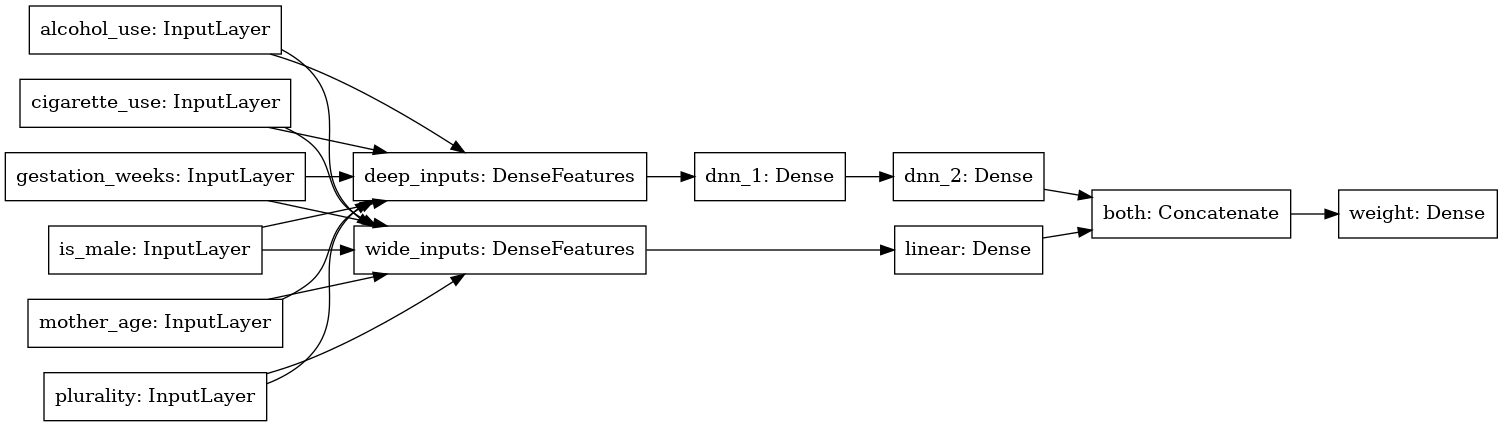

In [33]:
tf.keras.utils.plot_model(model=model, to_file="figures/wd_model.png", show_shapes=False, rankdir="LR")

## Run and evaluate model

### Train and evaluate.

We've built our Keras model using our inputs from our CSV files and the architecture we designed. Let's now run our model by training our model parameters and periodically running an evaluation to track how well we are doing on outside data as training goes on. We'll need to load both our train and eval datasets and send those to our model through the fit method. Make sure you have the right pattern, batch size, and mode when loading the data. Also, don't forget to add the callback to TensorBoard.

In [38]:
TRAIN_DATA_PATH = "subdatasets_preprocessed_Pandas/train.csv"
EVAL_DATA_PATH = "subdatasets_preprocessed_Pandas/eval.csv"
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset repeats, it'll wrap around
NUM_EVALS = 5  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000 # Enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset(
    pattern=TRAIN_DATA_PATH,
    batch_size=TRAIN_BATCH_SIZE,
    mode='train')

evalds = load_dataset(
    pattern=EVAL_DATA_PATH,
    batch_size=1000,
    mode='eval').take(count=NUM_EVAL_EXAMPLES // 1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

logdir = os.path.join(
    "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, histogram_freq=1)

history = model.fit(
    trainds,
    validation_data=evalds,
    epochs=NUM_EVALS,
    steps_per_epoch=steps_per_epoch,
    callbacks=[tensorboard_callback])

Epoch 1/5
  1/312 [..............................] - ETA: 0s - loss: 49.8490 - mse: 49.8490 - rmse: 7.0604 - r_squared: -24.3198WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
312/312 [==============================] - 3s 11ms/step - loss: 1.8594 - mse: 1.8594 - rmse: 1.2369 - r_squared: -0.1493 - val_loss: 1.2178 - val_mse: 1.2178 - val_rmse: 1.1033 - val_r_squared: 0.2908
Epoch 2/5
312/312 [==============================] - 2s 8ms/step - loss: 1.1921 - mse: 1.1921 - rmse: 1.0806 - r_squared: 0.2711 - val_loss: 1.1960 - val_mse: 1.1960 - val_rmse: 1.0933 - val_r_squared: 0.3092
Epoch 3/5
312/312 [==============================] - 2s 7ms/step - loss: 1.1541 - mse: 1.1541 - rmse: 1.0628 - r_squared: 0.2811 - val_loss: 1.1256 - val_mse: 1.1256 - val_rmse: 1.0607

### Visualize loss curve

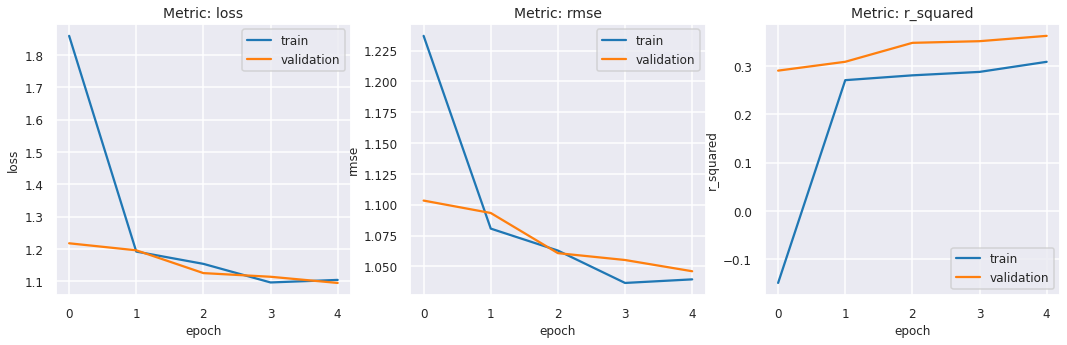

In [45]:
# Plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 3
fig = plt.figure(figsize=(18, 5))

for idx, key in enumerate(["loss", "rmse","r_squared"]):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history[f"val_{key}"])
    plt.title(f"Metric: {key}")
    plt.ylabel(key)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"])
    
plt.savefig('figures/trial_model_performance.png')

### Save the model

In [46]:
OUTPUT_DIR = "model_trained_subdatasets_Pandas"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR, datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
tf.saved_model.save(obj=model, export_dir=EXPORT_PATH)  # with default serving function
print(f"Exported trained model to {EXPORT_PATH}")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_trained_subdatasets_Pandas/20211023063208/assets
Exported trained model to model_trained_subdatasets_Pandas/20211023063208


In [47]:
!ls $EXPORT_PATH

assets	saved_model.pb	variables


## Summary:
In this notebook, we started by defining the CSV column names, label column, and column defaults for our data inputs. Then, we constructed a tf.data Dataset of features and the label from the CSV files and created inputs layers for the raw features. Next, we set up feature columns for the model inputs and built a wide and deep neural network in Keras. We created a custom evaluation metric and built our wide and deep model. Finally, we trained and evaluated our model.

Once we're satisfied with our local model, we can then scale it out to the cloud to get real performance evaluation.